# User adoption analysis
This project examines factors associated with user adoption of a project management tool.

The analysis has two main tasks:
1. Identify adopted users by wrangling a user login file.
2. Extracting features associated with user via supervised learning.

I also included an exploratory data analysis (see Appendix A).

### Initial import and inspection of data files


In [48]:
import warnings 
warnings.simplefilter('ignore')

# Importing basic packages used
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

Two data files were given for the analysis, one of user engagement (a list of time-stamped logins), and one of user features. Both are loaded below.
##### User engagement data

We loaded the engagement data into a dataframe and found 8823 users with 207917 total logins.

In [2]:
# Import the file
df_engagement = pd.read_csv('takehome_user_engagement.csv')

# Convert date and drop old timestamp column
df_engagement['date_visited'] = pd.to_datetime(df_engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S').dt.date
df_engagement = df_engagement.drop('time_stamp', axis=1)

# Print out head and basic info on user logins
print(df_engagement.head())
print('There were {} users and {} total logins'.format(df_engagement['user_id'].nunique(), len(df_engagement)))

   user_id  visited date_visited
0        1        1   2014-04-22
1        2        1   2013-11-15
2        2        1   2013-11-29
3        2        1   2013-12-09
4        2        1   2013-12-25
There were 8823 users and 207917 total logins


##### User features data

The user features datafile indicated 12,000 user profiles had been created.

In [3]:
# Choose the columns to import from the csv
cols = ['object_id', 'creation_time', 'creation_source', 'last_session_creation_time', 
        'opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'email']

# Import the data
df_profiles = pd.read_csv('takehome_users.csv', encoding='latin', usecols=cols)
# Convert the creation time column into a date, company definitions run by day
df_profiles['creation_date'] = pd.to_datetime(df_profiles['creation_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df_profiles = df_profiles.drop('creation_time', axis=1)
# Convert the last session time to a date, company definition runs by day
df_profiles['last_session_date'] = pd.to_datetime(df_profiles.last_session_creation_time, unit='s').dt.date
df_profiles = df_profiles.drop('last_session_creation_time', axis=1)
df_profiles.head()

,object_id,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date
0,1,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22,2014-04-22
1,2,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2013-11-15,2014-03-31
2,3,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19,2013-03-19
3,4,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-21,2013-05-22
4,5,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-17,2013-01-22


##### Checking file consistency
There were 12,000 users in the profiles data but only 8,823 in the engagement file, a discrepancy worth understanding, if only as a sanity check. Joining the two datasets gave the desired 8,823 rows, which shows that the extra rows in the profiles dataset were of those who signed up but never logged in.

In [4]:
# Create a df of ids from the user login data
ids_engagement = df_engagement.groupby('user_id').sum().reset_index()
# Check those ids match the user profiles data
merged_sanity_check = pd.merge(ids_engagement, df_profiles, left_on='user_id', right_on='object_id')
print('Merging both files gave {} matched rows'.format(merged_sanity_check.shape[0]))

Merging both files gave 8823 matched rows


## 1. Identifying adopted users
Adopted users are defined as those who logged in on at least three separate days within any 7-day window.
The user login data showed <b>1,656 adopted users</b> out of 8,823 total users. 19% of users are adopted users.

In [5]:
# define a function to see if a user logged in 3 or more separate days in a week
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by date
    df = df.drop_duplicates(subset='date_visited').sort_values('date_visited')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date_visited'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

# run the function on all users
adopted = df_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

print('There were {} adopted users out of {} users'.format(sum(adopted), len(adopted)))
print('{:1%} of users were adopted users'.format(    sum(adopted)/ len(adopted)))


There were 1656 adopted users out of 8823 users
18.769126% of users were adopted users


## 2. Features associated with being an adopted user

Management want to know what might predict a <u><i>future</i> adopted user</u>. As such, data leakage is a key machine learning issue. In this instance, leakage would occur when we use some proxy for adopted user status as a predictor in any model. Because adopted user status is based on user history over time, we should not be using predictors that include any information about usage over time in our models. We want to predict future adopted users, not just use information on their usage history to predict their current user status.

Another way to put this is that it is trivially true that people who have used our platform a long time (and those who have logged in recently) are adopted users. But a long-history is not a causal factor for user adoption, it is simply definitional ('someone with a long usage history IS an adopted user'), and will not help us to predict future users.

#### 2.0 Merging the adoption status into the features file

In [20]:
# Merge the adopted users into the user profile data
df = pd.merge(adopted.reset_index(), df_profiles, left_on='user_id', right_on='object_id').drop('object_id', axis=1).set_index('user_id')
df.adopted_user = df.adopted_user.astype(int)

#### 2.1 Removing censored cases

Before doing the machine learning, we first needed to remove any censored cases (users whose adoption status might be unknown). For example, we would not know whether someone who joined the platform one week before the end of our data logins collection would later become an adopted user. BUT, our procedure for calculating adopted users meant such people were coded as 'not adopted users'. This error introduces noise into our outcome variable. So we needed to remove those.

In order to do so, we first examined how long it takes for someone to become an adopted user. 
It takes, on average, 50 days for users to become adopted users (see chart below), and this tended to come in three distinct spikes: one spike in the first week, a second group about a month in, and then a smaller group around two months in (see future analyses for further discussion of these spikes).

As such, it made sense to remove accounts created in the last 50 days. There were 932 users with accounts created in the last 50 days (10.5% of all accounts), removing these left 7,891 data points for prediction.

In [21]:
# Making the date of adoption function and then applying it to the dataframe
def first_adoption3(df):
    ''' This function takes a dataframe and column name, latter in quotes,
    and returns the date a user first adopted a program. First adoption
    is defined as three or more days of logging in over a week.'''
    from datetime import timedelta
    df = df.reset_index()
    for i in range(len(df)-2):
        if df.loc[i+2, 'date_visited'] - df.loc[i, 'date_visited'] <= timedelta(days=7):
            return (df.loc[i+2, 'date_visited'])
            break
            
df['adoption_date'] = df_engagement.groupby('user_id').apply(first_adoption3)

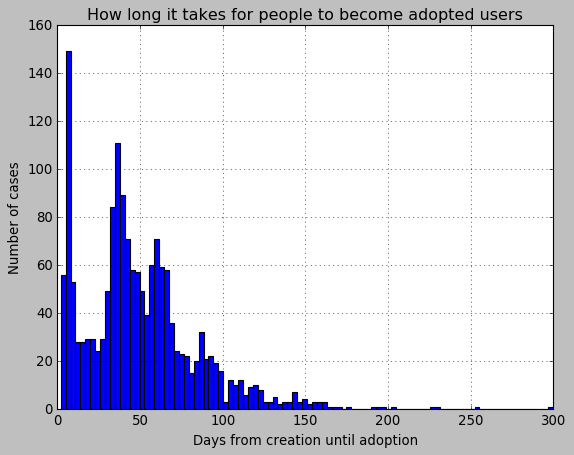

The average time it takes to adopt the platform is 50 days


In [22]:
# Charting the time it takes for users to adopt the platform
df['time_to_adopt'] = (df['adoption_date']-df['creation_date'])
dtp = df.time_to_adopt.dt.days
dtp.hist(bins=100)
plt.title('How long it takes for people to become adopted users')
plt.xlabel('Days from creation until adoption')
plt.ylabel('Number of cases')
plt.style.use('classic')
plt.show()

# Calculating the mean for adoption time
print('The average time it takes to adopt the platform is {:.0f} days'.format(np.mean(df.time_to_adopt.dt.days)))

In [23]:
print('Most recent user created on {}'.format(df.creation_date.max()))
print('Last login recorded on {}'.format(df_engagement.date_visited.max()))
print('Users created after {} should be removed'.format(df_engagement.date_visited.max() - dt.timedelta(50)))

Most recent user created on 2014-05-30
Last login recorded on 2014-06-06
Users created after 2014-04-17 should be removed


In [26]:
# Make the data frame without censored cases
df = df[df.creation_date <= df_engagement.date_visited.max() - dt.timedelta(50)]
print('After removing the censored points, there were {} cases left.'.format(df.shape[0]))
print('After cleaning, {:1%} of cases were adopted users'.format(sum(adopted)/ len(df.creation_date)))

After removing the censored points, there were 7891 cases left.
After cleaning, 20.985933% of cases were adopted users


#### 2.1 Recoding & feature engineering

Before running the machine learning, we explored and recoded variables where appropriate, as noted below. For further details on these analyses, see the appendix (which contains my EDA).
1. Email provider. There were six main email providers with counts over 800, all others having 2 or less. The six main were kept, and the others were combined into one 'other' category.
2. Invited by user. About 1/3 of users had no invite, and no user gave more than 13 invites. This variable was recoded into an indicator variable (0 for no invitation, 1 for an invitation).
3. Organizational ID. There were 417 unique organizational IDs, and we have no further information on the nature, names or structure of these organizations. As such, we removed this ID from the machine learning model as it would be likely to cause issues with fitting and then still not be interpretable.

In [27]:
# Recode emails
df['email_provider'] = [x.split('@')[1] for x in df.email] #select out the domain
#df.email_provider.value_counts() # this shows that there are six main providers
top_emails = df.email_provider.value_counts().index[:6]

#label anything not in the top 6 as other
df['email_provider'] = [x if x in top_emails else 'other' for x in df.email_provider]

In [28]:
# Recoding invited_by_user_id into an indicator variable
df['invited_by_user_ind'] = df['invited_by_user_id'] > 0
df['invited_by_user_ind'] = df['invited_by_user_ind'].astype(int)

In [29]:
df.head()

,adopted_user,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,adoption_date,time_to_adopt,email_provider,invited_by_user_ind
user_id,,,,,,,,,,,,,
2,1,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2013-11-15,2014-03-31,2014-02-09,86 days,gustr.com,1
3,0,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19,2013-03-19,None,NaT,gustr.com,1
4,0,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-21,2013-05-22,None,NaT,yahoo.com,1
5,0,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-17,2013-01-22,None,NaT,yahoo.com,1
6,0,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,11241.0,2013-12-17,2013-12-19,None,NaT,yahoo.com,1


In [30]:
# Invitation inspection
#df.invited_by_user_id.fillna(0).value_counts()
# Org ID inspection
#df.org_id.value_counts()

#### 2.2 Feature selection
The problem of leakage seems large in this dataset. Specifically, our outcome variable is based on login dates, and hence these are associated with such variables as creation date and last session date. To include date-based variables in our model would, in this instance, inflate the accuracy of our model. Another way to put it is that we want to predict <b>future</b> adopted users, so putting in current usage data (e.g. last login) would not help us in our future prediction.
As such, we did not include creation date or last login date as predictors.

<b>This left us with 5 predictors:</b>
1. Creation source.
2. Mailing list opt-in
3. Marketing drip
4. Email type
5. Invitation by user

Creation source and email type were given dummy variables.

In [31]:
df.email_provider = df.email_provider.astype('category')
df.creation_source = df.creation_source.astype('category')

#### 2.3 Fittting the random forest model.

The machine learning approach we used is outlined below:
1. Algorithm chosen: random forest, because it handles categorical variables and interactions easily
2. Pre-processing: all variables were categorical, and those with more than two categories were one-hot encoded
3. Class imbalance was addressed by balancing in the random forest algorithm
4. Evaluation was via accuracy on the test set.
5. Feature importance was assessed via a permutation test, which is less biased in the presence of multi-category variables (as for creation source and email provider).
6. Cross-validation was conducted to tune the number of trees.

The machine learning model is instantiated and fit below.

All variables were categorical, and those with more than two categories were one-hot encoded.

In [32]:
X = df[['invited_by_user_ind', 'enabled_for_marketing_drip', 
        'opted_in_to_mailing_list', 'creation_source',
        'email_provider']]
y = df[['adopted_user']]
X.head()

,invited_by_user_ind,enabled_for_marketing_drip,opted_in_to_mailing_list,creation_source,email_provider
user_id,,,,,
2,1,0,0,ORG_INVITE,gustr.com
3,1,0,0,ORG_INVITE,gustr.com
4,1,0,0,GUEST_INVITE,yahoo.com
5,1,0,0,GUEST_INVITE,yahoo.com
6,1,0,0,GUEST_INVITE,yahoo.com


In [64]:
# Check the shapes are the same
print('features and predictors have same shape: {}'.format(X.shape[0] == y.shape[0]))

# Import modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
# Split data sets first

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)
print('features and predictors in TRAINING set have same shape: {}'.format(Xtrain.shape[0] == ytrain.shape[0]))
print('features and predictors in TEST set have same shape: {}'.format(Xtest.shape[0] == ytest.shape[0]))     

# Pre-processing the columns
#cat_pipe = Pipeline(('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')), # Set up the ohe
mult_cat_cols = ['email_provider', 'creation_source'] # Select multiple category columns
binary_cols = ['invited_by_user_ind', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list']
#cat_transformers = [('cat', cat_pipe, cat_cols)] # Make transformer step
ct = ColumnTransformer([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), mult_cat_cols),
                      ('binary', 'passthrough', binary_cols)]) # Make column transformer


# Make a pipeline with the column pre-processing and the RF
rf = Pipeline([
    ('preprocess', ct),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


# use cross-validation to tune number of trees
params = {'clf__n_estimators': [1, 2, 5, 10, 50, 100, 200]}
model = GridSearchCV(rf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)

features and predictors have same shape: True
features and predictors in TRAINING set have same shape: True
features and predictors in TEST set have same shape: True
Best parameters were {'clf__n_estimators': 5}


#### 2.4 Evaluation of the model
The model was evaluted using a number of measures, in three basic classes: comparison of training and test samples, and a classification report

##### 2.4.1 Comparison of test and training scores

The training and test accuracy were very similar (~64%). Both were better than chance (50% given the balancing of classes). This suggests our model is informative and not overfitted.

In [70]:
ypred = model.predict(Xtest) # make the predictions on the test set
print('Accuracy of test set was {:.2%}'.format(accuracy_score(ytest, ypred)))
ypred2 = model.predict(Xtrain)
print('Accuracy of training set was {:.2%}'.format(accuracy_score(ytrain, ypred2)))

Accuracy of test set was 64.27%
Accuracy of training set was 64.31%


##### 2.4.2 Classification report

The classification report showed results typical of imbalanced classes.
As stated above, overall accuracy (64%) was above chance but not excedingly impressive.
<br> Given management's interest in predicting future adopted users, performance with respect to that class is perhaps most importance. 25% of predictions that a user was an adopted user were correct, and the model found 38% of the adopted users. This is to be expected given the imbalanced classes (<20% adopted users).
<br> Of lesser interest is the model's performance for non-adopted users. The model was correct 82% of the time when it predicted a target was a non-adopted users, and it found 71% of that class.

In [119]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1567
           1       0.25      0.38      0.31       406

    accuracy                           0.64      1973
   macro avg       0.54      0.55      0.53      1973
weighted avg       0.70      0.64      0.67      1973



#### 2.5 Feature importance
Feature importance was assessed via a permutation test because it is unaffected by variables with different numbers of categories (i.e. creation source and email provider had multiple values).
<br><b> The most important variables were creation source, an invitation from a current user, and email provider.</b>
<br>Two creation sources, invitations and personal projects, had the most adopted users (see chart A.1, below)
<br>An invitation from a current user increased likelihood of becoming an adopted user (see chart A.2, below)
<br>Hotmail users were most likely to be adopted users (see chart A.3. below)

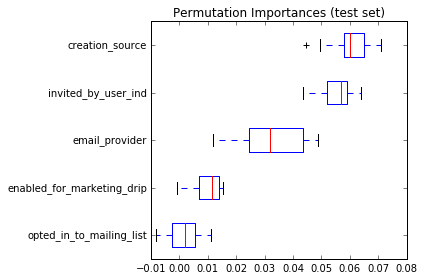

In [118]:
# Evaluate feature importance via permutation test
result = permutation_importance(model, Xtest, ytest, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=Xtest.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Conclusions

Overall, we learned the following from this analysis:
1. It takes, on average, 50 days after account creation for someone to become an adopted user.
2. Being invited and or personal hobby usage are the best predictors of adoption, with Hotmail users being another good target.
3. The data allowed prediction at better than chance levels, but the imbalance in the non/adopted classes led to typical prediction problems.

There are several warnings around this analysis, too:
1.  The results do improve significantly if data leakage is allowed (by allowing date of adoption and recent usage to be predictors in the model), but this is not a helpful approach to take when trying to predict future users.
2. Removing censored users matters.

<br> <b>Ideas for followup analyses:</b> 
1. Future analyses could investigate predictors of the length of time until adoption, rather than adopting the somewhat arbitrary binary outcome given in the definition of adopted user. Adopted users become so after about 50 days, on average, but what speeds up and slows down that process?
2. Does the day of week of signup or the month of the year have an effect on becoming an adopted user?

## Appendix A. EDA

Before conducting machine learning, each potential predictor was explored for its relationship with the outcome.

##### A.1 Creation source. 
The number of adopted users differed by creation source (see graph below, $\chi^2$ = 41.28, $p$ < .0005). Those signing up due to a guest invitation or a personal project appear to be more likely to be an adopted user. 

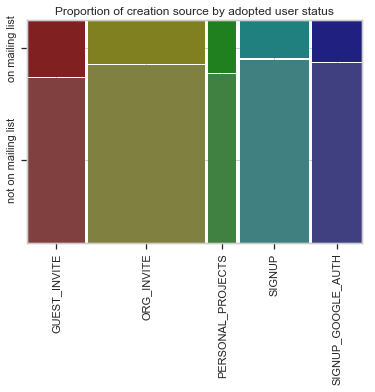

In [149]:
%matplotlib inline
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
ct = pd.crosstab(df['creation_source'], df['adopted_user'])
ct.columns=['not on mailing list', 'on mailing list']
_ = mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005], label_rotation=90,
       title='Proportion of creation source by adopted user status')
plt.show()

In [121]:
chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq stat was {:.2f} with p = {:6f}'.format(chisq, p))

The χ-sq stat was 40.28 with p = 0.000000


##### A.2 Invitation by current user
Being invited by a current user is associated with being an adopted user (see graph below, $\chi^2$ = 6.36, $p$ =.01)

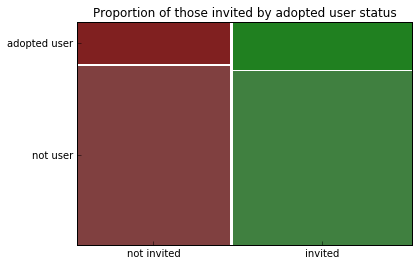

In [122]:
%matplotlib inline
ct = pd.crosstab(df['invited_by_user_ind'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not invited', 'invited']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of those invited by adopted user status')
plt.show()

In [123]:
chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

The χ-sq statistic was 6.64 with p = 0.01


##### A.3 Email provider
Different email providers are associated with different levels of adopted users (see graph below, $\chi^2$ = 39.12, $p$ < 0.005). Hotmail users are most likely to be adopted users.

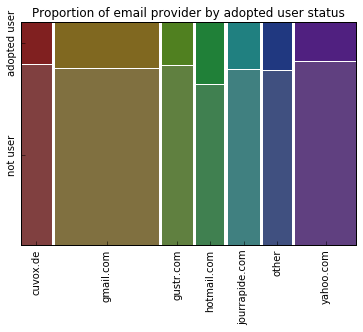

In [124]:
%matplotlib inline
ct = pd.crosstab(df['email_provider'], df['adopted_user'])
ct.columns = ['not user','adopted user']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of email provider by adopted user status', label_rotation=90)
plt.show()

In [126]:
chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.7f}'.format(chisq, p))

The χ-sq statistic was 35.81 with p = 0.0000030


##### A.4 Mailing list opt-in

Mailing list opt-in does not appear to be associated with being an adopted user (see graph below, $\chi^2$ = 0.45, $p$ =.50)

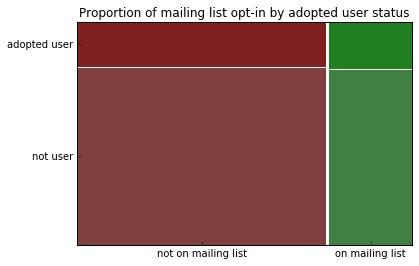

In [127]:
%matplotlib inline
ct = pd.crosstab(df['opted_in_to_mailing_list'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not on mailing list', 'on mailing list']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of mailing list opt-in by adopted user status')
plt.show()

In [128]:
chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

The χ-sq statistic was 0.56 with p = 0.46


##### A.5 Marketing drip enabled
Marketing drip is not associated with being an adopted user (see graph below, $\chi^2$ = 0.13, $p$ =.72)

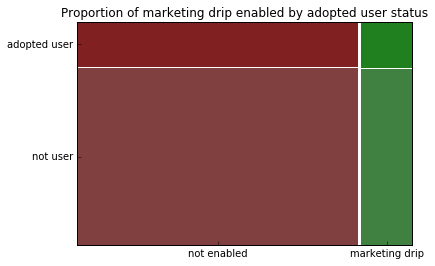

In [129]:
%matplotlib inline
ct = pd.crosstab(df['enabled_for_marketing_drip'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not enabled', 'marketing drip']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of marketing drip enabled by adopted user status')
plt.show()

In [130]:
chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

The χ-sq statistic was 0.11 with p = 0.74


##### A.6 Creation date
Although not analyzed in the machine learning model, we analyzed new account creations each month. New accounts increased over time, the last month is simply incomplete.

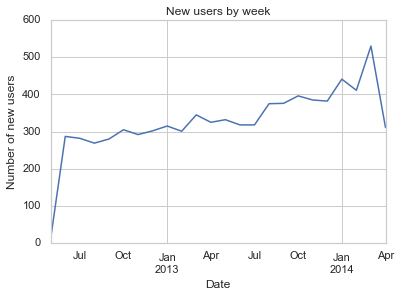

In [240]:
# Create data frame with date-time index by creation date
df_new = df.sort_values('creation_date').set_index(pd.DatetimeIndex(df['creation_date']))
# Resample to week and plot
_ = df_new.resample('1M').count().org_id.plot()
_ = plt.title('New users by week')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of new users')
plt.show()